In [1]:
import pandas as pd
pd.set_option("display.precision", 7)
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import figure
import yfinance as yf
from dateutil import parser
from statistics import mean, pstdev
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
import warnings
warnings.filterwarnings('ignore')
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from sklearn.preprocessing import power_transform
from tqdm import tqdm

In [2]:
def plot_box_cox(col):
    fitted_data, fitted_lambda = stats.boxcox(col)
    
    fig, ax = plt.subplots(1, 2)
    sns.distplot(col, hist = False, kde = True,
               kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Non-Normal", color ="green", ax = ax[0])

    sns.distplot(fitted_data, hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 2}, 
                label = "Normal", color ="green", ax = ax[1])

    plt.legend(loc = "upper right")

    fig.set_figheight(5)
    fig.set_figwidth(10)

    print(f"Lambda value used for Transformation: {fitted_lambda}")
    return fitted_data

def bc(col):
    fitted_data, fitted_lambda = stats.boxcox(col)
    return (fitted_data, fitted_lambda)

    
def plott(x, y1, y2, title):
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(20)
    ax.plot(x, y1,color = "#1f77b4")

    ax2=ax.twinx()
    ax2.plot(x, y2,color="#ff7f0e", alpha = 0.5)
    plt.title(title)
    plt.show()
    
def plot_3_graphs(x,y,z,w, title, lab1, lab2, lab3):
    host = host_subplot(111, axes_class=AA.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    p1, = host.plot(x, y, label = lab1)
    p2, = par1.plot(x, z, label = lab2, alpha=0.5)
    p3, = par2.plot(x, w, label = lab3, alpha=0.5)
    host.legend()
    
    plt.title(title)
    plt.draw()
    plt.show()

def parse_data_1(filename):
    cols = ["unix", "open", "high", "low", "close", "volume", "tbqav", "tbbav", "qav", "noftrades"]
    data = pd.read_csv(filename, sep = "|", header=None, names = cols)
    data = data[["unix","open","low","close","high","volume"]]
    data["volume"].replace({0: 0.000000000000001}, inplace=True)
    return data
    
def vwap(df):
    v = df['volume'].values
    tp = (df['low'] + df['close'] + df['high']).div(3).values
    
    return df.assign(vwap=(tp * v).cumsum() / v.cumsum())

# ETH

In [3]:
data = parse_data_1("ETHUSDT.csv")[:220]
unix = data.unix
close = data.close

Lambda value used for Transformation: 62.58800951887935
Lambda value used for Transformation: 62.58638958654915
Lambda value used for Transformation: 62.58679058498824
Lambda value used for Transformation: 0.13290328937054144


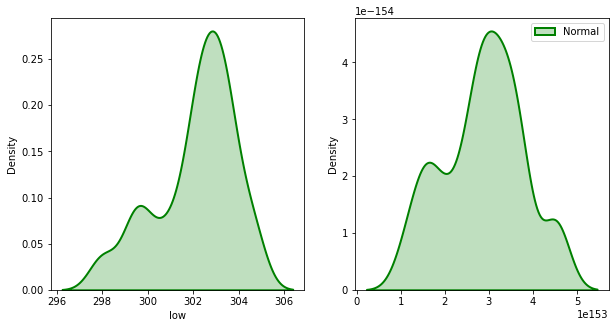

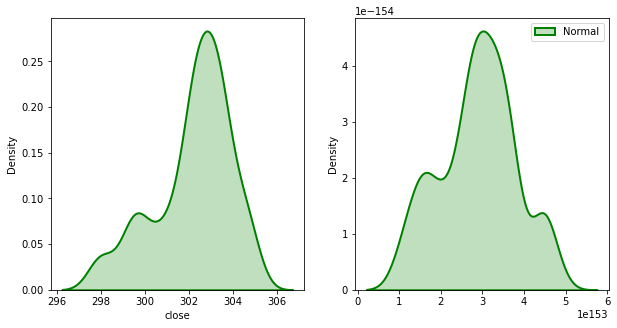

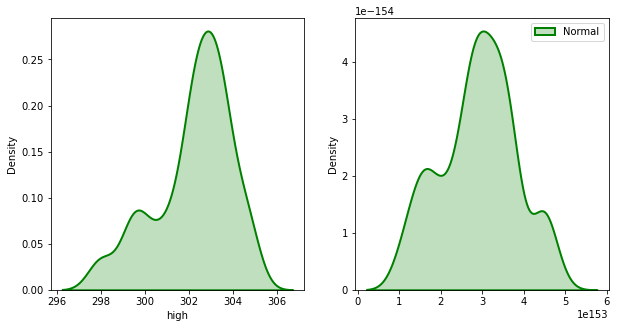

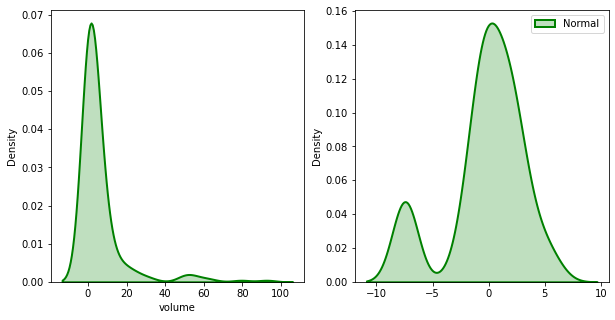

In [4]:
bcdata = pd.DataFrame(
    index = data.unix,
    data = {
        "low": plot_box_cox(data.low),
        "close": plot_box_cox(data.close),
        "high": plot_box_cox(data.high),
        "volume": plot_box_cox(data.volume),
    }
)

Lambda value used for Transformation: 62.69155972488033


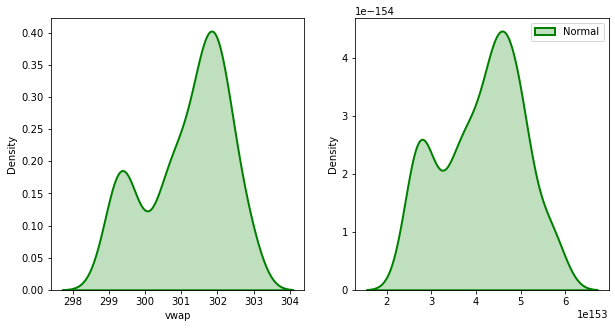

In [5]:
bc_vwap = vwap(bcdata).vwap
vwap_bc = plot_box_cox(vwap(data).vwap)

### Close vs Bc(Vwap) vs Vwap(bc)

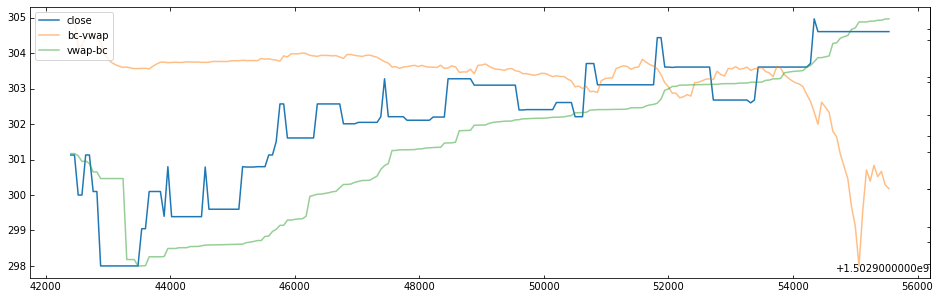

In [6]:
plot_3_graphs(unix, close, bc_vwap, vwap_bc , "", "close", "bc-vwap", "vwap-bc")

## Returns

Lambda value used for Transformation: 8.472135811722177


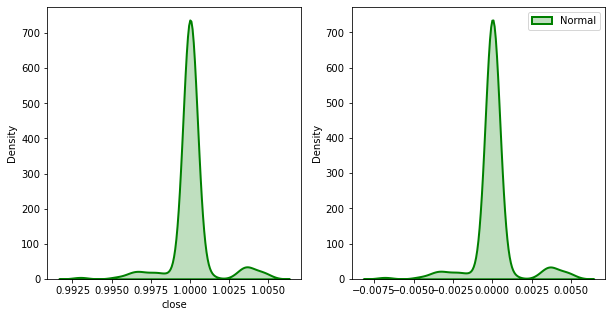

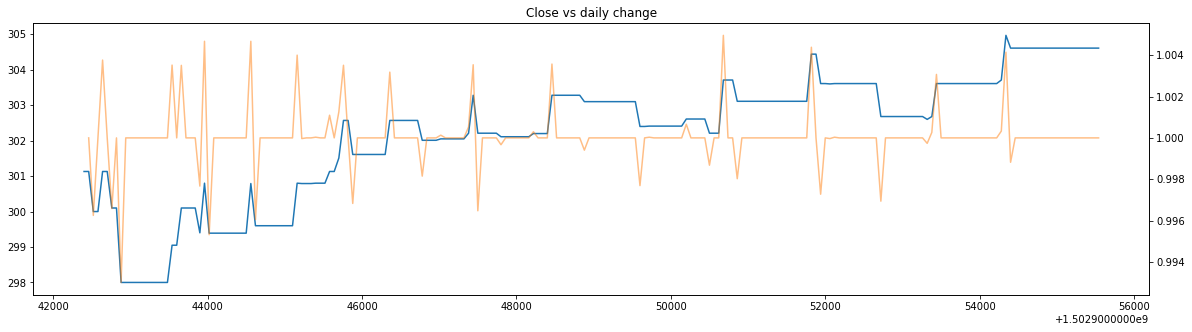

In [7]:
returns = close.div(close.shift()).fillna(np.nan)
bc_returns = plot_box_cox(returns)
plott(unix, close, returns, "Close vs daily change")

In [8]:
std = np.nanstd(returns)
mean = np.nanmean(returns)
bcstd = np.nanstd(bc_returns)
bcmean = np.nanmean(bc_returns)
print(std, mean, bcstd, bcmean)

0.0013407948410869373 1.0000533668073994 0.0013423917559310507 6.009859579718758e-05


In [9]:
testdf = pd.DataFrame({
    'close':close,
    'vwap_bc':vwap_bc,
    'returns': returns,
    'bcreturns': bc_returns,
    'unix': unix
                  })

In [10]:
markers = testdf[testdf.bcreturns > 3*bcstd]
mclose = markers.close
mindex = markers.unix

### Set markers where boxcox(returns) > 3*std of boxcox(returns)

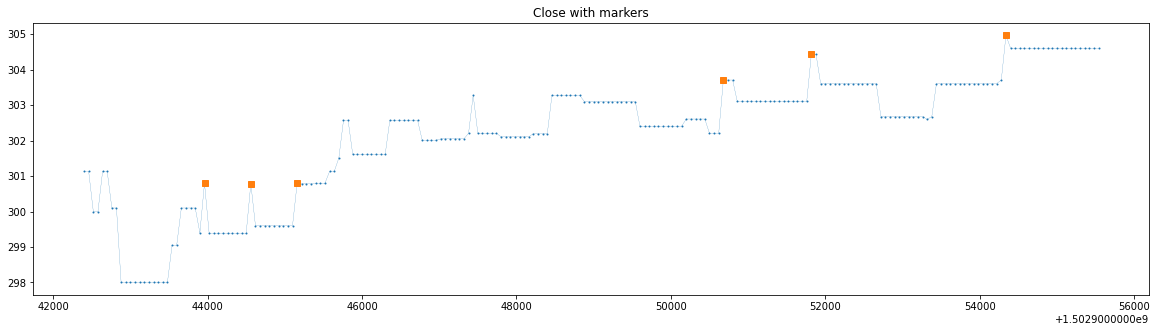

In [11]:
plt.plot(unix, close, "-o", linewidth=0.2, markersize=1)
plt.title("Close with markers")
plt.plot(mindex, mclose, "s")